## Note: remember to start postgresql server!

**There are multiple ways to launch a postgres server:**

1) Launching Postres.app from LaunchPad will automatically start a server.  In Mac OS, you should see an elephant icon in the upper right corner.

2) Launch from the terminal with the following command (CHANGE USER NAME):<br>

    postgres -D /Users/rockson/Library/Application\ Support/Postgres/var-9.6
    
3) Have launchd start postgresql at login:<br>

    ln -sfv /usr/local/opt/postgresql/*.plist ~/Library/LaunchAgents

Then to load postgresql now: <br>

    launchctl load ~/Library/LaunchAgents/homebrew.mxcl.postgresql.plist

In [1]:
## Python packages
import time
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define a database name and username for this computer
dbname = 'osha_db'
username = 'asc'

# Define connection to database
con = None
con = psycopg2.connect(database = dbname, user = username)

## Create a database

In [3]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

postgres://asc@localhost/osha_db


In [4]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
# Data dir
data_dir = '/Users/asc/Documents/Insight/test_projects/OSHA/data/'

In [ ]:
create_tables = False

In [ ]:
# CREATE TABLE OF INSPECTION DATA

sql_query = '''

CREATE TABLE inspections_table(
activity_nr integer NULL,
reporting_id integer NULL,
state_flag char(2) NULL,
estab_name text NULL,
site_address text NULL,
site_city text NULL,
site_state text NULL,
site_zip integer NULL,
owner_type char(1) NULL,
owner_type_definition text NULL,
owner_code text NULL,
adv_notice char(1) NULL,
safety_hlth char(1) NULL,
safety_hlth_definition text NULL,
sic_code char(4) NULL,
naics_code char(6) NULL,
insp_type char(1) NULL,
insp_type_definition text NULL,
insp_scope char(1) NULL,
insp_scope_definition text NULL,
why_no_insp char(1) NULL,
why_no_insp_definition text NULL,
union_status char(1) NULL,
union_status_definition text NULL,
safety_manuf char(1) NULL,
safety_const char(1) NULL,
safety_marit char(1) NULL,
health_manuf char(1) NULL,
health_const char(1) NULL,
health_marit char(1) NULL,
migrant char(1) NULL,
mail_street text NULL,
mail_city text NULL,
mail_state char(2) NULL,
mail_zip char(5) NULL,
host_est_key text NULL,
nr_in_estab integer NULL,
open_date date NULL,
case_mod_date date NULL,
close_conf_date date NULL,
close_case_date date NULL,
ld_dt timestamp NULL);


COPY inspections_table FROM 
'/Users/asc/Documents/Insight/test_projects/OSHA/data/7a743434-d016-4c87-b85a-28af3fc78abb_OSHA-InspectionReport.csv' 
WITH DELIMITER ',' HEADER CSV;

SELECT activity_nr FROM inspections_table;

'''


if create_tables:
    inspection_table = pd.read_sql_query(sql_query,con)

In [ ]:
# CREATE TABLE OF VIOLATION DATA
# 
#
# activity_nr,citation_id,pen_fta,pen_fta_definition,hist_event,
# hist_event_definition,hist_date,hist_penalty,hist_abate_date,
# hist_vtype,hist_insp_nr,load_dt

sql_query = '''
CREATE TABLE violations_table(
activity_nr integer NULL,
citation_id text NULL,
pen_fta char(1) NULL,
pen_fta_definition text NULL,
hist_event char(1) NULL,
hist_event_definition text NULL,
hist_date date NULL,
hist_penalty float NULL,
hist_abate_date date NULL,
hist_vtype text NULL,
hist_insp_nr text NULL,
ld_dt timestamp NULL);


COPY violations_table FROM 
'/Users/asc/Documents/Insight/test_projects/OSHA/data/9c14534c-d40a-4c29-8714-e1f29005b3bc_OSHA-ViolationEvent.csv' 
WITH DELIMITER ',' HEADER CSV;

COMMIT;

SELECT activity_nr, hist_penalty FROM violations_table;

'''

if create_tables:
    violations_table = pd.read_sql_query(sql_query,con)

In [ ]:
sql_query = '''
SELECT activity_nr, SUM(hist_penalty) FROM violations_table GROUP BY activity_nr;
'''
violations_data_from_sql = pd.read_sql_query(sql_query,con)

# CLEAN DATA (ON DATABASE)

In [ ]:
clean_tables = False

In [ ]:
## Homogeneize labor union affiliations

sql_query = '''
UPDATE inspections_table 
SET union_status='Y'
WHERE union_status='A' OR union_status='U';

UPDATE inspections_table
SET union_status='N'
WHERE union_status='B' or union_status IS NULL;

'''
if clean_tables:
    pd.read_sql_query(sql_query,con)

# CREATE TARGET VALUES (ON DATABASE)

In [ ]:
create_targets = False

In [ ]:
# Create additional column with all zeros
if create_targets:
    sql_query = '''
    ALTER TABLE inspections_table
    ADD is_violation integer DEFAULT 0;
    ADD is_violation integer DEFAULT 0;

    COMMIT;
    '''

    pd.read_sql_query(sql_query,con)
    
    # Turn into ones the zeros corresponding to violation events
    print "ATTENTION! This execution can be pretty slow. Be patient ..."
    # NOTE: there may be a more efficient way of doing this via SQL LEFT JOIN command.
    #       See https://www.w3schools.com/sql/sql_join_left.asp
    #

    sql_query = '''
    UPDATE inspections_table
    SET is_violation=1
    WHERE activity_nr IN
    (SELECT activity_nr FROM violations_table);

    COMMIT;
    '''

    print "WATCH! This command will place matching values (with is_violation==1) at the BOTTOM of table."

    pd.read_sql_query(sql_query,con)

# FEATURE ENGINEERING

In [6]:
def sic_division(sic_code):
    #
    # Given a 4-digit SIC code, return division abbreviation
    # 
    
    # First, ensure sic_code is integer
    if (not isinstance( sic_code, int )):
        
        if (sic_code is None):
            # If data is missing, return 0
            division = "0"
            return division
        else:
            # If not missing, convert to int
            sic_code=int(sic_code)
        
    if (sic_code<100 or sic_code>9999):
        print "Warning: SIC code value ", sic_code, " is outside range (0100-9999)"
        division = "0"
    if (sic_code>=100 and sic_code<=999):
        # Agriculture, Forestry and Fishing
        division = "A"
    elif (sic_code>=1000 and sic_code<=1499):
        # Mining
        division = "B" 
    elif (sic_code>=1500 and sic_code<=1799):
        # Construction
        division = "C"
    elif (sic_code>=1800 and sic_code<=1999):
        print "Error: SIC code value ", sic_code, " is in excluded range (1800-1999)"
        quit()
    elif (sic_code>=2000 and sic_code<=3999):
        # Manufacturing
        division = "D"
    elif (sic_code>=4000 and sic_code<=4999):
        # Transportation, Communications, Electric, 
        # Gas and Sanitary service
        division = "E"
    elif (sic_code>=5000 and sic_code<=5199):
        # Wholesale trade
        division = "F"
    elif (sic_code>=5200 and sic_code<=5999):
        # Retail trade
        division = "G"
    elif (sic_code>=6000 and sic_code<=6799):
        # Finance, Insurance and Real Estate
        division = "H"
    elif (sic_code>=7000 and sic_code<=8999):
        # Services
        division = "I"
    elif (sic_code>=9000 and sic_code<=9099):
        # undetermined
        print "Warning: SIC code value ", sic_code ," is in excluded range (9000-9099)"
        division = "0"
    elif (sic_code>=9100 and sic_code<=9729):
        # Public Administration
        division = "J"
    elif (sic_code>=9730 and sic_code<=9899):
        # undetermined
        print "Warning: SIC code value ", sic_code ," is in excluded range (9730-9900)"
        division = "0"
    elif (sic_code>=9900 and sic_code<=9999):
        # Nonclassifiable
        division = "K"
    
    return division

# Selecting potentially useful data for analysis

In [121]:
sql_query = '''
SELECT 
owner_type, nr_in_estab, union_status, sic_code, is_violation
FROM inspections_table;
'''
usa_data = pd.read_sql_query(sql_query, con)
usa_data.head()

,owner_type,nr_in_estab,union_status,sic_code,is_violation
0,A,2.0,Y,1796,0
1,A,20.0,Y,1742,0
2,A,170.0,N,4953,0
3,A,9.0,N,7513,0
4,A,2.0,Y,1791,0


In [31]:
sql_query = '''
SELECT * FROM inspections_table
WHERE site_city='New York' OR site_city='NEW YORK' OR site_city='new york' 
OR site_city='NEW YORK CITY' OR site_city='New York City' OR site_city='new york city'
OR site_city='Brooklyn' OR site_city='BROOKLYN' OR site_city='brooklyn' 
OR site_city='QUEENS' OR site_city='Queens' OR site_city='queens' 
OR site_city='BRONX' OR site_city='Bronx' OR site_city='bronx'
OR site_city='STATEN ISLAND' OR site_city='Staten Island' OR site_city='staten island'
AND site_state='NY';
'''
nyc = pd.read_sql_query(sql_query, con)
nyc

,activity_nr,reporting_id,state_flag,estab_name,site_address,site_city,site_state,site_zip,owner_type,owner_type_definition,...,mail_state,mail_zip,host_est_key,nr_in_estab,open_date,case_mod_date,close_conf_date,close_case_date,ld_dt,is_violation
0,300592979,215600,None,CALCEDO CONSTRUCTION CORP,HARDING AVE. & EAST 177TH ST.,BRONX,NY,10465.0,A,Private,...,NY,10532,None,2.0,1996-06-27,None,1996-06-27,1996-08-20,2011-10-14 16:38:47.457300,0
1,108903626,213400,None,KING KULLEN,"244 ARDEN AVE., STORE #21",STATEN ISLAND,NY,10312.0,A,Private,...,NY,10317,None,100.0,1993-01-13,None,1993-01-13,1993-01-22,2011-10-14 16:38:47.457300,0
2,316681030,253650,None,NYSOMH MANHATTAN PSYCH CTR,1 WARDS ISLAND,NEW YORK,NY,10035.0,C,StateGovt,...,NY,12229,N074 000007328,45.0,2012-10-09,2013-06-28,2012-10-11,2012-10-11,2013-07-01 01:01:24.279900,0
3,124504044,253650,None,NYS PA BUS TERMINAL POLICE,41 ST & 8 AVE,NEW YORK,NY,10048.0,C,StateGovt,...,NY,10048,N074 000007516,300.0,1998-06-03,2011-11-10,1998-06-03,1998-06-03,2011-11-29 01:00:50.279400,0
4,106933484,215000,None,D.M.J. FASHION CORP.,"467 TROUTMAN ST.,2ND FL.",BROOKLYN,NY,11237.0,A,Private,...,None,00000,None,20.0,1993-11-18,None,1993-11-18,1993-11-18,2011-10-14 16:38:47.457300,0
5,124526948,253650,None,COUNSELS' OFFICE NYSDOL,1 MAIN ST RM 1201,BROOKLYN,NY,11201.0,C,StateGovt,...,NY,12240,None,12.0,1994-03-17,None,1994-03-17,1994-03-17,2011-10-14 16:38:47.457300,0
6,309598357,216000,None,"AFFORDABLE LEATHER PRODUCTS, INC.","565 BARRY STREET, 2ND FLOOR SUITE C",BRONX,NY,10474.0,A,Private,...,None,00000,N152 000009647,15.0,2007-03-12,2007-09-10,2007-03-12,2007-03-12,2011-10-14 16:38:47.457300,0
7,315610634,215000,None,NATIONAL GRID CORP.,WATER STREET AND WASHINGTON ST,BROOKLYN,NY,11201.0,A,Private,...,NY,11211,N160 000027050,20.0,2011-06-02,2011-06-09,2011-06-02,2011-06-03,2011-10-14 16:38:47.457300,0
8,124578402,253650,None,NYCDOT SI FERRY TERMINALS,ST GEORGE & WHITEHALL,STATEN ISLAND,NY,10301.0,B,LocalGovt,...,NY,10007,N074 000007611,400.0,2000-01-14,None,2000-01-14,2000-01-14,2011-10-14 16:38:47.457300,0
9,102781028,215600,None,VERDICO INDUSTRIES INC.,80-20 134TH STREET,QUEENS,NY,11435.0,A,Private,...,NY,11003,None,9.0,1992-03-20,None,1992-03-20,1992-04-03,2011-10-14 16:38:47.457300,0


In [32]:
sql_query = '''
SELECT * FROM inspections_table
WHERE site_city='Las Vegas' OR site_city='LAS VEGAS' OR site_city='las vegas' 
AND site_state='NV';
'''
vegas = pd.read_sql_query(sql_query, con)
vegas 

,activity_nr,reporting_id,state_flag,estab_name,site_address,site_city,site_state,site_zip,owner_type,owner_type_definition,...,mail_state,mail_zip,host_est_key,nr_in_estab,open_date,case_mod_date,close_conf_date,close_case_date,ld_dt,is_violation
0,305703738,953220,None,"SOUTHERN NEVADA PAVING, INC.",2875 EAST CHARLESTON BLVD.,LAS VEGAS,NV,89101,A,Private,...,NV,89103,N057 000010933,2.0,2002-10-22,2008-01-07,2002-10-30,2002-10-30,2011-10-14 16:38:47.457300,0
1,306787920,953220,None,"SILVER STAR PLUMBING, INC.",5875 INDUSTRIAL RD.,LAS VEGAS,NV,89118,A,Private,...,NV,89101,N057 000021044,3.0,2003-07-17,None,2003-08-25,2003-08-25,2011-10-14 16:38:47.457300,0
2,304419229,953220,None,"STRUCTURES, INC.",255 EAST FLAMINGO ROAD,LAS VEGAS,NV,89109,A,Private,...,AZ,85299,N057 000019544,12.0,2001-03-29,2008-01-17,2001-03-30,2001-03-30,2011-10-14 16:38:47.457300,0
3,305454068,953220,None,"BOMBARD ELECTRIC COMPANY, INC.",100 CITY PARKWAY,LAS VEGAS,NV,89109,A,Private,...,NV,89118,N057 000016193,35.0,2002-04-11,2007-01-31,2002-05-21,2002-05-21,2011-10-14 16:38:47.457300,0
4,305455255,953220,None,"SOUTHERN NEVADA PAVING, INC.",10950 WEST CHARLESTON BLVD.,LAS VEGAS,NV,89135,A,Private,...,NV,89103,N057 000018639,3.0,2002-05-29,2008-07-21,2002-06-14,2002-06-14,2011-10-14 16:38:47.457300,0
5,104676226,953220,None,"CARL'S DONUTS, INC.",501 SOUTH MARTIN LUTHER KING BLVD.,LAS VEGAS,NV,89106,A,Private,...,None,00000,N057 000000357,22.0,1989-03-09,2007-12-13,1989-03-09,1989-03-09,2011-10-14 16:38:47.457300,0
6,304420623,953220,None,"QUANTUM GLASS & MIRROR, INC.",4560 SOUTH DECATUR,LAS VEGAS,NV,89103,A,Private,...,NV,89104,N057 000016333,2.0,2001-04-16,2007-12-17,2001-04-30,2001-04-30,2011-10-14 16:38:47.457300,0
7,313968927,953220,None,"SIGNS WEST, INC.","5325 POLARIS AVENUE, SUITE 500",LAS VEGAS,NV,89118,A,Private,...,None,00000,N057 000032898,28.0,2009-12-03,2010-03-29,2010-03-02,2010-03-02,2011-10-14 16:38:47.457300,0
8,307581595,953220,None,"CARL'S DONUTS, INC.",6350 SUNSET CORPORATE DRIVE,LAS VEGAS,NV,89120,A,Private,...,None,00000,N057 000022457,20.0,2004-03-11,None,2004-03-15,2004-03-15,2011-10-14 16:38:47.457300,0
9,102057882,953220,None,MYS DRYWALL & ACOUSTICS INC,4265 W TROPICANA AVE,LAS VEGAS,NV,89103,A,Private,...,NV,89108,None,16.0,1987-08-21,None,1987-08-24,1987-08-24,2011-10-14 16:38:47.457300,0


In [ ]:
sql_query = '''
SELECT 
activity_nr, site_state, site_zip, owner_type, adv_notice, 
safety_hlth, sic_code, naics_code, insp_type, insp_scope, 
union_status, migrant, nr_in_estab, is_violation
FROM inspections_table;
'''
insp_df = pd.read_sql_query(sql_query, con)

In [ ]:
insp_df.head()

In [122]:
# Aggregate SIC numbers by division
usa_data['sic_code'] = usa_data['sic_code'].apply(sic_division)

In [123]:
# Replace NaN
usa_data['nr_in_estab'].fillna(0, inplace=True)

In [124]:
usa_data.columns

Index([u'owner_type', u'nr_in_estab', u'union_status', u'sic_code',
       u'is_violation'],
      dtype='object')

In [131]:
from sklearn.model_selection import train_test_split

my_data = usa_data

X = pd.get_dummies(my_data, columns=['sic_code', 'owner_type', 'union_status'])

# 'sic_code_0', 
X = X[['sic_code_A', 'sic_code_B',
       'sic_code_C', 'sic_code_D', 'sic_code_E', 'sic_code_F',
       'sic_code_G', 'sic_code_H', 'sic_code_I', 'sic_code_J',
       'sic_code_K', 
       'owner_type_A', 'owner_type_B', 'owner_type_C', 'owner_type_D', 
       'union_status_N', 'union_status_Y','nr_in_estab' 
      ]] #'insp_scope_A', 'insp_scope_B', 'insp_scope_C', 'insp_scope_D'] ]

Y = my_data['is_violation']

# Save for later use
feature_labels = X.columns


In [132]:
p1= float(sum(Y))/Y.shape[0] 
print "Proportions of class 1"
print "   Training data: ", p1

Proportions of class 1
   Training data:  0.255160867857


In [133]:
p1_usa = float(sum(usa_data['is_violation'].values))/usa_data.shape[0]
p1_nyc = float(sum(nyc['is_violation'].values))/nyc.shape[0]
p1_vegas = float(sum(vegas['is_violation'].values))/vegas.shape[0]

In [138]:
p1_usa

0.2551608678568901

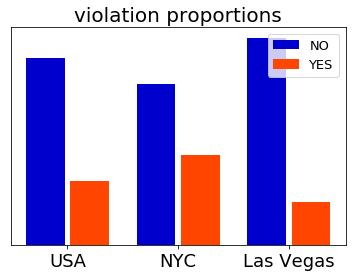

In [99]:
# Plot proportions


fs=18
width=0.35
sep = 0.05

p1_all = np.array([p1_usa, p1_nyc, p1_vegas])
p0_all = 1.0-p1_all

x0 = np.arange(0,3)
x1 = x0+width+sep


fig, ax = plt.subplots()
r0 = ax.bar(x0, p0_all, width=width, color= 'mediumblue')
r1 = ax.bar(x1, p1_all, width=width, color= 'orangered')
ax.set_title('violation proportions', fontsize=fs+2)
ax.set_xticks(0.5*(x0+x1))
ax.set_xticklabels(['USA', 'NYC', 'Las Vegas'], fontsize=fs)
ax.set_yticklabels([])
ax.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',      # ticks along the top edge are off
    labelbottom='off')#, length=0), # labels along the bottom edge are off
    
#ax.set_xlabel('violations?', fontsize=fs)
#ax.set_ylabel('class proportions', fontsize=fs)
ax.legend((r0[0], r1[0]), ('NO', 'YES'), loc=1, fontsize=fs-5)
plt.savefig('violation_proportions.png')

In [114]:
# 
def balance_data(x,t):
    # Balance data.
    #   x: np.array containing features
    #   t: np.array containing targets
    
    
    # If DataFrame or Series, convert to np.array
    if (isinstance(x, pd.DataFrame) or isinstance(x, pd.Series)):
        x = x.values
        
    if (isinstance(t, pd.DataFrame) or isinstance(t, pd.Series)):
        t = t.values
    
    
    # Check that dimensions agree
    if (np.shape(x)[0] != np.shape(t)[0]):
        print ("ERROR! Lengths of x and t do not agree. Exiting ... ")
        exit()
    
    # Find indices
    iHD=np.array(np.where(t == 0))
    iLD=np.array(np.where(t == +1))
    
    # Count HD and LD
    NHD=np.size(iHD)
    NLD=np.size(iLD)
    
    
    # Create balanced set
    if(NLD <= NHD):
        # Take all LD points and NLD random HD points
        Nhalf=NLD
        ibal=np.zeros(2*Nhalf, dtype=np.int)
        
        ibal[:Nhalf]=iLD[0,:]
        np.random.shuffle(iHD)
        
        ibal[Nhalf:]=iHD[0,:Nhalf]
        
    elif(NLD > NHD):
        # Take all HD points and NHD random LD points
        Nhalf=NHD
        ibal=np.zeros(2*Nhalf, dtype=np.int)
        
        ibal[:Nhalf]=iHD[0,:]
        np.random.shuffle(iLD)
        
        ibal[Nhalf:]=iLD[0,:Nhalf]
        
    
    # Shuffle points so that HD and LD are mixed
    np.random.shuffle(ibal)
    

    # Return shuffled balanced data 
    return x[ibal,:], t[ibal]    

In [134]:
# Balance data set -- downsampling
X, Y = balance_data(X,Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=np.random.seed(int(time.time())))

p1_train = float(sum(y_train))/y_train.shape[0] 
p1_test = float(sum(y_test))/y_test.shape[0]
print "Proportions of class 1"
print "   Training data: ", p1_train
print "   Test data:     ", p1_test

Proportions of class 1
   Training data:  0.500302004125
   Test data:      0.499093988676


In [ ]:
# Downsample largest component
#X_bal, Y_bal = balance_data(X,Y)

In [135]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)
# AUC (area under the curve) is insensitive of unbalanced classes
# ROC curve

0.637466785381


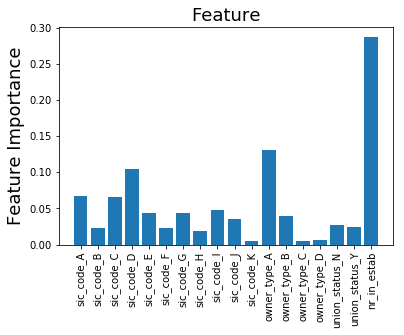

In [139]:
# Plot feature importance

fs=18

Nbars=np.shape(clf.feature_importances_)[0]

fig, ax = plt.subplots()


ax.bar(np.arange(0,Nbars), clf.feature_importances_)
ax.set_xticks(np.arange(0,Nbars))
ax.set_xticklabels(feature_labels, rotation='vertical')

ax.set_ylabel('Feature Importance', fontsize=fs)
ax.set_title('Feature', fontsize=fs)
plt.savefig('feature_importance.png',  bbox_inches='tight')

In [ ]:
from sklearn import tree


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print clf.score(X_test, y_test)      


In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
print logreg.score(X_test, y_test)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

# The export_graphviz exporter also supports a variety of aesthetic options, 
# including coloring nodes by their class (or value for regression) and using 
# explicit variable and class names if desired. Jupyter notebooks also render 
# these plots inline automatically:


dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 



In [ ]:
np.random.random()